In [ ]:
!pip install facenet-pytorch

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alfredhhw/adiencegender")

print("Path to dataset files:", path)

100%|██████████| 2.62G/2.62G [02:00<00:00, 23.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alfredhhw/adiencegender/versions/1


In [2]:
IMAGE_DIR = "/root/.cache/kagglehub/datasets/alfredhhw/adiencegender/versions/1/AdienceGender/aligned/"

In [3]:
import os
import re
import numpy as np
import pandas as pd
import torch
from PIL import Image
import cv2
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.manifold import TSNE

In [4]:
adience_df = pd.read_csv("https://drive.google.com/uc?id=11a8GW8PXR5jYWQCb73-7IzOTYUR6abQc&export=download")

In [5]:
adience_df

,image_path,age
0,30601258@N03/landmark_aligned_face.1.103996468...,"(25, 32)"
1,30601258@N03/landmark_aligned_face.2.104248158...,"(25, 32)"
2,30601258@N03/landmark_aligned_face.1.104379798...,"(25, 32)"
3,30601258@N03/landmark_aligned_face.3.104379798...,"(25, 32)"
4,30601258@N03/landmark_aligned_face.2.118166449...,"(25, 32)"
...,...,...
13963,101515718@N03/landmark_aligned_face.2280.10587...,"(25, 32)"
13964,101515718@N03/landmark_aligned_face.2278.10587...,"(25, 32)"
13965,101515718@N03/landmark_aligned_face.2279.10587...,"(25, 32)"
13966,50458575@N08/landmark_aligned_face.2281.942669...,"(25, 32)"


In [6]:
adience_df['image_path'] = adience_df['image_path'].astype(str)
adience_df['age'] = adience_df['age'].apply(eval)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
mtcnn = MTCNN(image_size=224, select_largest=True, keep_all=True, device=device)

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3, fill=0),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
adience_df = adience_df[adience_df['age'] != (8, 23)]

In [11]:
sorted(adience_df["age"].unique())

[(0, 2), (4, 6), (8, 12), (15, 20), (25, 32), (38, 48), (48, 53), (60, 100)]

In [12]:
class AdienceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.age_range_to_index = {
            age_range : idx
            for idx, age_range in enumerate(sorted(self.dataframe["age"].unique()))
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row["image_path"]
        label = self.age_range_to_index[row["age"]]
        label = torch.tensor(label, dtype=torch.long)

        image = Image.open(IMAGE_DIR + image_path)
        image = image.resize((224, 224))

        faces, _ = mtcnn.detect(image)

        if faces is None:
            image = Image.open(IMAGE_DIR + image_path)
            image = image.resize((224, 224))
        else:
            largest_face_box = faces[0]
            image = image.crop((largest_face_box[0], largest_face_box[1], largest_face_box[2], largest_face_box[3]))

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
dataset = AdienceDataset(adience_df, transform=transform)
train_size = int(0.7 * len(dataset))
# val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [14]:
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
num_classes = 8

In [16]:
# model = models.efficientnet_b0(pretrained=True)
# num_ftrs = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

In [17]:
# model = models.vgg16(pretrained=True)
# num_ftrs = model.classifier[-1].in_features
# model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

In [18]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 168MB/s]


In [19]:
model = model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  # Total loss across all samples
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)  # Average loss per sample
    train_accuracy = 100 * correct_train / total_train

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation Phase
    # model.eval()  # Set model to evaluation mode
    # val_loss = 0.0
    # correct_val = 0
    # total_val = 0

    # with torch.no_grad():  # No gradient computation in validation phase
    #     for images, labels in val_loader:
    #         images, labels = images.to(device), labels.to(device)

    #         # Forward pass
    #         outputs = model(images)
    #         loss = criterion(outputs, labels)
    #         val_loss += loss.item() * images.size(0)

    #         # Calculate accuracy
    #         _, predicted = torch.max(outputs, 1)
    #         correct_val += (predicted == labels).sum().item()
    #         total_val += labels.size(0)

    # avg_val_loss = val_loss / len(val_loader.dataset)
    # val_accuracy = 100 * correct_val / total_val

    # print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

print("Training complete.")

Epoch [1/5], Training Loss: 1.2999, Training Accuracy: 51.05%
Epoch [2/5], Training Loss: 1.0453, Training Accuracy: 59.96%
Epoch [3/5], Training Loss: 0.9444, Training Accuracy: 63.37%
Epoch [4/5], Training Loss: 0.8644, Training Accuracy: 66.83%
Epoch [5/5], Training Loss: 0.7868, Training Accuracy: 69.97%
Training complete.


In [23]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/MyDrive/densenet121_weights.pth')

Mounted at /content/drive


In [24]:
model.eval()

correct_test = 0
total_test = 0

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Calculate and print the final test accuracy
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

conf_matrix = confusion_matrix(all_labels, all_predictions)

precision, recall, f1_score, support = precision_recall_fscore_support(all_labels, all_predictions)

print("Confusion Matrix:\n", conf_matrix)
print("\nPrecision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1_score)
print("Samples per class:", support)


Test Accuracy: 68.73%
Confusion Matrix:
 [[ 617   32    4    1    3    1    0    0]
 [  89  338   20    0   10    0    0    0]
 [   3   81  272   17   46    2    0    0]
 [   1    8   34  119  175    0    0    0]
 [   5    9   42   24 1182   42    0    3]
 [   0    0   16    2  364  159    7   14]
 [   1    1    2    0   58   41   35   50]
 [   2    0    1    0   30   39   11  115]]

Precision per class: [0.85933148 0.7206823  0.69565217 0.73006135 0.63276231 0.55985915
 0.66037736 0.63186813]
Recall per class: [0.93768997 0.73960613 0.64608076 0.35311573 0.90436113 0.28291815
 0.18617021 0.58080808]
F1-score per class: [0.89680233 0.7300216  0.66995074 0.476      0.74456693 0.37588652
 0.29045643 0.60526316]
Samples per class: [ 658  457  421  337 1307  562  188  198]


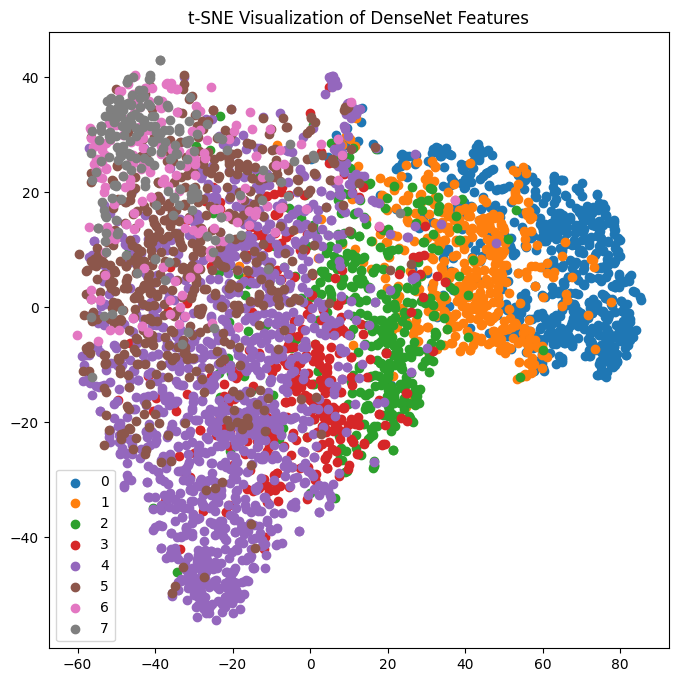

In [26]:
features = []
labels = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        outputs = feature_extractor(images)
        features.append(outputs.view(outputs.size(0), -1).cpu())
        labels.append(label.cpu())

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.figure(figsize=(8, 8))
for label in set(labels):
    plt.scatter(
        reduced_features[labels == label, 0],
        reduced_features[labels == label, 1],
        label=str(label)
    )
plt.legend()
plt.title("t-SNE Visualization of DenseNet Features")
plt.show()